<a href="https://colab.research.google.com/github/cderose/dh-courses/blob/master/Word_embeddings_notebook.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

<i>This notebook makes use of a large pretrained word embedding model that will take a few minutes to download. Please run the cell below to start downloading that pretrained model so it can download while we start our exploration of word embeddings below!</i>

In [ ]:
!wget -nc https://s3.amazonaws.com/lab-data-collections/GoogleNews-vectors-negative300.bin.gz
!yes n | gunzip GoogleNews-vectors-negative300.bin.gz

--2023-05-29 21:22:53--  https://s3.amazonaws.com/lab-data-collections/GoogleNews-vectors-negative300.bin.gz
Resolving s3.amazonaws.com (s3.amazonaws.com)... 3.5.1.116, 54.231.168.96, 52.217.70.38, ...
Connecting to s3.amazonaws.com (s3.amazonaws.com)|3.5.1.116|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 1647046227 (1.5G) [application/octet-stream]
Saving to: ‘GoogleNews-vectors-negative300.bin.gz’

GoogleNews-vectors- 100%[===================>]   1.53G  15.6MB/s    in 1m 57s  

2023-05-29 21:24:52 (13.4 MB/s) - ‘GoogleNews-vectors-negative300.bin.gz’ saved [1647046227/1647046227]



# Getting started with word embeddings

Word embeddings (also called *word vectors*) are data structures that map sequences of alphabetic characters (*words*) to lists of numbers (*vectors*). 

The vector space of a word embedding model is generally semantic, so words that appear in similar regions of the space typically have similar semantic meanings. As we'll see below, there are other properties of these vector spaces that make them interesting to analyze!

# Why study word embeddings?

Word embeddings have been used in all sorts of research applications, and are certainly worth exploring if your work touches on any of the following domains:

 * <b>Multilingual and Cross-lingual analysis</b>: If you work on works in translation, or on the influence of writers who write in one language on those who write in another language, word vectors can valuable ways to study these kinds of cross-lingual relationships algorithmically.  
  [[Case Study: Using word vectors to study endangered languages](https://raw.githubusercontent.com/YaleDHLab/lab-workshops/master/word-vectors/papers/coeckelbergs.pdf)]
 * <b>Studying Language Change over Time</b>: If you want to study the way the meaning of a word has changed over time, word vectors provide an exceptional method for this kind of study.  
  [[Case Study: Using word vectors to analyze the changing meaning of the word "gay" in the twentieth century.](https://nlp.stanford.edu/projects/histwords/)]
 * <b>Analyzing Historical Concept Formation</b>: If you want to analyze the ways writers in a given historical period understood particular concepts like "honor" and "chivalry", then word vectors can provide excellent opportunities to uncover these hidden associations.  
 [[Case Study: Using word vectors to study the ways eighteenth-century authors organized moral abstractions](https://raw.githubusercontent.com/YaleDHLab/lab-workshops/master/word-vectors/papers/heuser.pdf)]
 * <b>Uncovering Text Reuse</b>: If you want to study text reuse or literary imitation (either within one language or across multiple languages), word vectors can provide excellent tools for identifying similar passages of text.  
 [[Case Study: Using word vectors to uncover cross-lingual text reuse in eighteenth-century writing](https://douglasduhaime.com/posts/crosslingual-plagiarism-detection.html)]

These are of course only a few of the many possible use cases for word vectors. The field is still new, so there are plenty of new applications you can discover!

# Introduction to word embeddings

"Word embeddings" (or "word vectors") are ways of representing semantic and syntactic information about words in a vector form. As you may recall, the word "vector" is just a fancy term for a list of numbers (or sometimes a list of number lists). Word vectors are a way of representing each word in a vocabulary with a list of numbers, such that those numbers can tell us useful information about the words in the vocabulary.

The simplest kind of word vector system represents each distinct word in a vocabulary with a `w` dimensional vector (or list of `w` numbers), where `w` equals the number of distinct words in the language. Each word's vector consists of zeros for all but the `i-th` value in the list, where `i` indicates the given word's index position within the vocabulary. This is known as a "[one-hot encoding](https://hackernoon.com/what-is-one-hot-encoding-why-and-when-do-you-have-to-use-it-e3c6186d008f)," as the vector contains 0s in all but one position.

For example, suppose one has a vocabulary consisting only of five words: King, Queen, Man, Woman, and Child. In that case one could encode the word "Queen" as:

<img src='https://raw.githubusercontent.com/YaleDHLab/lab-workshops/master/word-vectors/images/word2vec-one-hot.png' style='width: 600px'>

<center>
<div style='text-align: center'><a href='https://blog.acolyer.org/2016/04/21/the-amazing-power-of-word-vectors/'>Image by Adrian Coyler</a></div>
</center>

While it's easy to represent words with this kind of one-hot encoding, these vectors don't give us any way to compare words except to check if they're equal, which isn't very helpful.

Recent approaches to word vectors, including Google's Word2Vec and Stanford University's GloVe embeddings, create more insightful word vectors by representing each word in a language with a dense `k` dimensional vector, where `k` is a value chosen by the user who creates the word vectors. (Dense vectors are lists of numbers in which there are very few if any zeros; unlike one-hot vectors which are comprised of all zeros with a single 1, dense vectors are comprised almost entirely of non-zero values). The meaning of each word is thereby represented by a list of `k` values, and each unit in the `k` dimensions contributes some meaning to each word.

If one were to label the dimensions in a word vector, the result might look something like the following:

<img src='https://raw.githubusercontent.com/YaleDHLab/lab-workshops/master/word-vectors/images/word2vec-distributed-representation.png' style='width: 600px'>

<center>
<div style='text-align: center'><a href='https://blog.acolyer.org/2016/04/21/the-amazing-power-of-word-vectors/'>Image by Adrian Coyler</a></div>
</center>

Each of these word vectors (the columns above) gives a representation of the semantic and syntactic function of a word in a language. By comparing these vectors, we can study relationships between words in ways that were previously not possible. To see how this works, let's dive into some code below.

# Creating word vectors with matrix factorization

You may recall that last week, we used Non-Negative Matrix Factorization to "factor" a Term Document Matrix **D** into two smaller matrices **W** and **T**:

<center>
<img src='https://raw.githubusercontent.com/YaleDHLab/lab-workshops/master/topic-modeling-python/images/matrix-factorization-intuition.jpg' height='400' />
</center>

The **T** matrix, we said at the time, contains one row for each topic in the model, and one column for each term in the model. In this way, the **T** matrix gives us a vector representation for each word in our corpus! 

If you wanted, you could use those word vectors for all of the experiments we will run below. As a matter of fact, this is essentially what the Stanford team that created the popular [GloVe word vectors](https://nlp.stanford.edu/projects/glove/) did (except the **D** matrix they factored into **W** and **T** consisted of term co-occurrence counts rather than term document counts). So you already know how to create word vectors! 

# Creating Word Vectors with Neural Networks

While we can generate word vectors with matrix vectorization, most practitioners today generate word vectors with neural networks, so that's the approach we'll take today. 

As you may recall from class discussion, neural networks are little programs that attempt to identify some internal numbers (or model weights) that, when plugged into the model's internal formula, minimize the difference between the model's output and the value the model should predict. 

To use a neural network to generate word vectors, we start with a corpus of texts:



In [ ]:
corpus = 'Yale University is a private Ivy League research university in New Haven, Connecticut'

We then find the set of unique words in our corpus and represent each word as a one-hot vector, just like we saw above:

In [ ]:
import numpy as np

# find the set of unique words
words = list(set(corpus.split()))

# initialize a matrix with all zeros
one_hot_vectors = np.zeros((len(words), len(words)))

# iterate over each word along with its index position
for index, i in enumerate(words):

  # make this vector one-hot -- e.g. set one of its values to 1
  one_hot_vectors[index][index] = 1

In [ ]:
one_hot_vectors

array([[1., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.],
       [0., 1., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.],
       [0., 0., 1., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.],
       [0., 0., 0., 1., 0., 0., 0., 0., 0., 0., 0., 0., 0.],
       [0., 0., 0., 0., 1., 0., 0., 0., 0., 0., 0., 0., 0.],
       [0., 0., 0., 0., 0., 1., 0., 0., 0., 0., 0., 0., 0.],
       [0., 0., 0., 0., 0., 0., 1., 0., 0., 0., 0., 0., 0.],
       [0., 0., 0., 0., 0., 0., 0., 1., 0., 0., 0., 0., 0.],
       [0., 0., 0., 0., 0., 0., 0., 0., 1., 0., 0., 0., 0.],
       [0., 0., 0., 0., 0., 0., 0., 0., 0., 1., 0., 0., 0.],
       [0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 1., 0., 0.],
       [0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 1., 0.],
       [0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 1.]])

At this point, each word is modeled as a one-hot vector. Let's fetch the one-hot vector for a word:

In [ ]:
one_hot_vectors[ words.index('Yale') ]

array([0., 0., 0., 0., 0., 0., 0., 0., 0., 1., 0., 0., 0.])

Once we have a one-hot vector representation of each word in our corpus, we pass a sliding window over each document in our corpus:

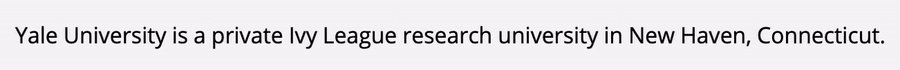

For each of those windows, we will find all combinations of words in the window:

In [ ]:
from itertools import combinations

# consider the list of words in the first window
window_words = ['Yale', 'University', 'is', 'a', 'private', 'Ivy']

# find each of the pairs of words in the window
for i in combinations(window_words, 2):

  # print the word pair
  print(i)

('Yale', 'University')
('Yale', 'is')
('Yale', 'a')
('Yale', 'private')
('Yale', 'Ivy')
('University', 'is')
('University', 'a')
('University', 'private')
('University', 'Ivy')
('is', 'a')
('is', 'private')
('is', 'Ivy')
('a', 'private')
('a', 'Ivy')
('private', 'Ivy')


Finally, for each of these word pairs, we can use our first word's one-hot vector to try and predict the second word's one-hot vector:



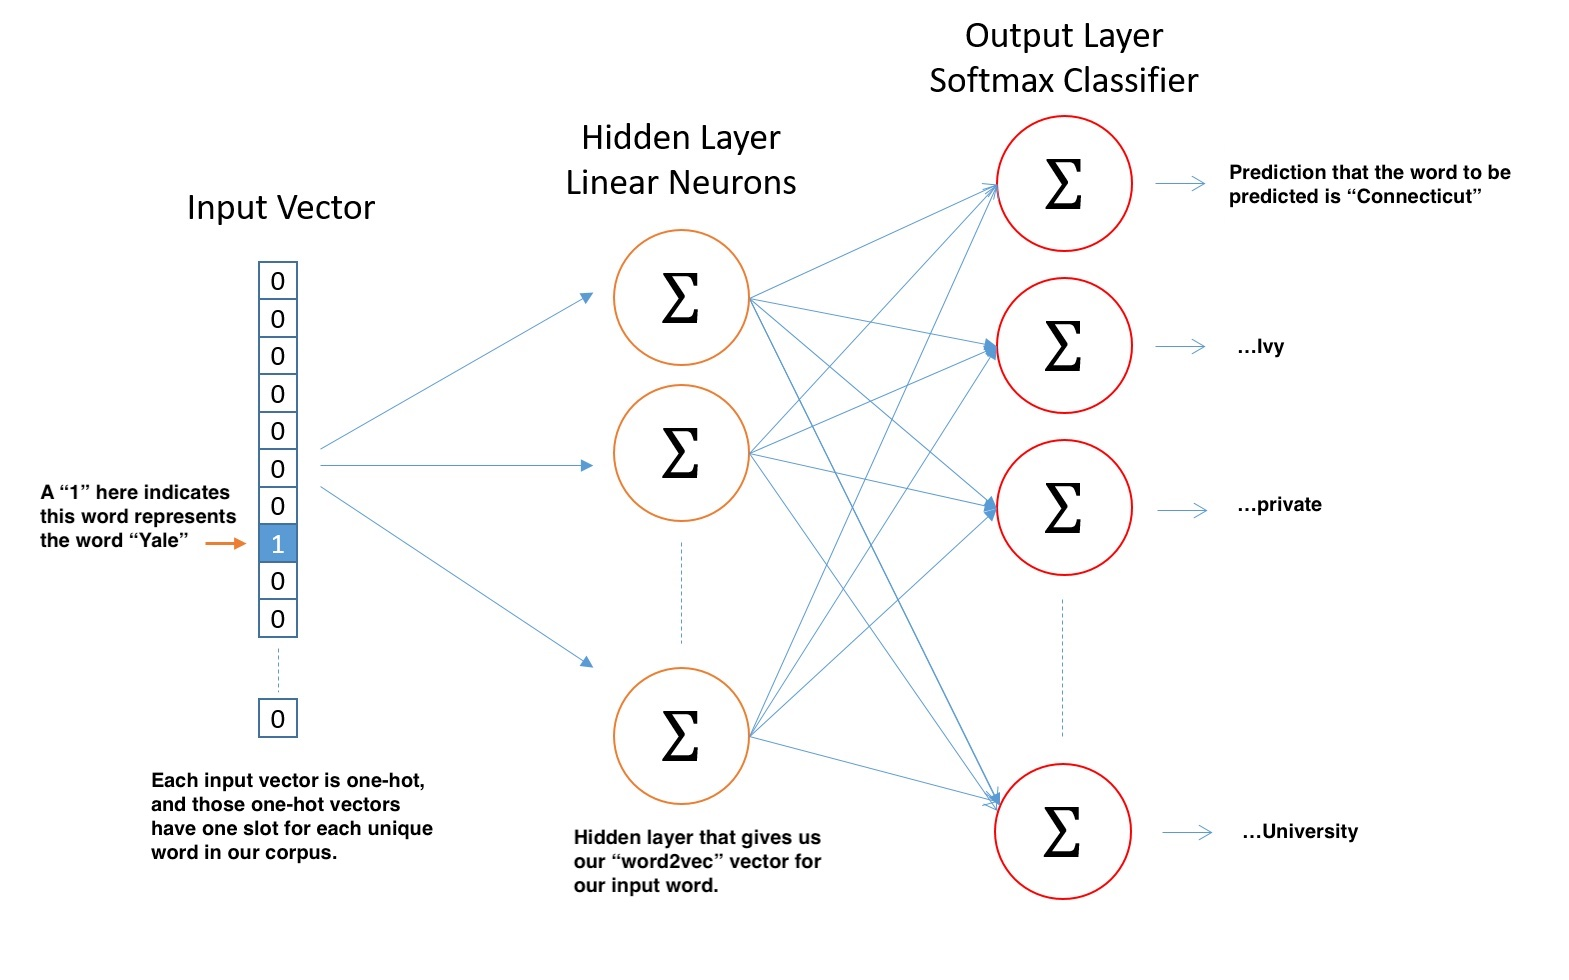

The diagram above shows the architecture of the network we can use to train our word vectors! We simply ask this network to predict one word given another, and we let the network update its internal weights until it's successful in this task. Once it is successful in this task, we can pass words into the model and extract the outputs of our hidden layer above. This output sequence will give us our representation of our word vector! That's all there is to it!

# Loading pretrained word vectors

In practice, we usually train the network architecture discussed above on large collections of data, which can take days or weeks. To help us hit the ground running, we'll start our word vector work with a *pretrained model*. Because this model is already trained, it will give us our model weights immediately!

The following section loads one of Google's pretrained language models. This model has already learned how to map each word in the dataset to a 300-dimensional vector — won't need to train it ourselves. The download takes a minute or two, but that's much faster than training a model from scratch, which can take days or weeks!

In [ ]:
!wget -nc https://s3.amazonaws.com/lab-data-collections/GoogleNews-vectors-negative300.bin.gz
!yes n | gunzip GoogleNews-vectors-negative300.bin.gz

--2023-05-30 01:19:49--  https://s3.amazonaws.com/lab-data-collections/GoogleNews-vectors-negative300.bin.gz
Resolving s3.amazonaws.com (s3.amazonaws.com)... 52.217.139.104, 52.217.160.88, 52.216.113.77, ...
Connecting to s3.amazonaws.com (s3.amazonaws.com)|52.217.139.104|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 1647046227 (1.5G) [application/octet-stream]
Saving to: ‘GoogleNews-vectors-negative300.bin.gz’

GoogleNews-vectors- 100%[===================>]   1.53G  41.2MB/s    in 37s     

2023-05-30 01:20:26 (42.3 MB/s) - ‘GoogleNews-vectors-negative300.bin.gz’ saved [1647046227/1647046227]



After downloading and unzipping our pretrained model, we will need to install the `gensim` package that we will use for our word vector work:

In [ ]:
!pip install gensim

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


Having installed the `gensim` package, we can use it to load our pretrained model as follows:

In [ ]:
from gensim.models import KeyedVectors

# initialize our word model using the pretrained model weights
model = KeyedVectors.load_word2vec_format('GoogleNews-vectors-negative300.bin', binary=True)  

Once the model loads, we can fetch the word vector for a particular word as follows:

In [ ]:
# obtain the word vector for the word "Boston"
model['Boston']

array([-1.75781250e-01,  1.90429688e-01,  3.19824219e-02,  2.75390625e-01,
        1.04980469e-01,  4.71191406e-02, -2.83203125e-01, -1.47460938e-01,
        6.17675781e-02, -1.53320312e-01, -2.26562500e-01,  1.54418945e-02,
        7.86781311e-05,  2.03125000e-01,  2.53906250e-01,  7.37304688e-02,
       -2.05078125e-02, -1.42578125e-01,  1.84570312e-01, -6.29882812e-02,
       -9.17968750e-02, -1.79687500e-01, -2.99072266e-02, -1.70898438e-01,
       -7.66601562e-02,  3.82812500e-01,  7.71484375e-02,  1.41601562e-01,
       -4.08203125e-01,  1.38671875e-01,  2.11914062e-01, -3.68652344e-02,
       -7.22656250e-02, -8.54492188e-02,  3.73535156e-02, -5.52368164e-03,
        1.27929688e-01, -2.22656250e-01, -2.38281250e-01,  2.55859375e-01,
        1.30859375e-01,  2.89306641e-02, -3.41796875e-02, -1.04492188e-01,
       -3.67187500e-01,  1.94335938e-01, -1.29882812e-01,  7.72094727e-03,
        4.55078125e-01,  1.25976562e-01,  1.07910156e-01,  3.55468750e-01,
        1.06933594e-01, -

The output above is just a list of 300 numbers (or a 300-dimensional vector). 

There are lots of things we can do with this vector! We'll focus on some of the different things we can do with word vectors below.

# Reviewing vectors

In our past session on topic modeling, we spent some time discussing Numpy arrays. Each of our word vectors in this session will also be a Numpy array. See if you can identify the shape of the vector that corresponds to the word "bulldogs" below:

In [ ]:
# see if you can identify the shape of the vector that corresponds to the word "bulldogs"
model['bulldogs'].shape

(300,)

<details>
  <summary>
  Solution
  </summary>

  We can identify the shape of the vector for bulldogs with the following:

  ```python
  model['bulldogs'].shape
  ```
</details>

# Identifying associated words

The first thing we might want to do with a word vectors is to find terms that are associated with a given word.

### Finding the top n words most similar to a query word

In the simplest use case, we might want to find the top n words whose vectors are most similar to a query word. (This is what Jonathan Fitzgerald did to identify the [words associated with "freedom" in the 17th, 18th, and 19th centuries](https://cssh.northeastern.edu/nulab/word-embedding-models-new-topic-models/).) In that case, we can use the helper function `similar_by_vector` defined on the `model`: 


In [ ]:
# extract the vector for the word "Yale"
vector = model['Yale']

# fetch the 3 words most similar to our query vector
model.similar_by_vector(vector, topn=3)

[('Yale', 1.0),
 ('Harvard', 0.7817696332931519),
 ('Cornell', 0.7190003395080566)]

In the output above we can see the three words that are closest to our query word in the vector space, as well as a measure of how close those vectors are in the vector space. 

### Measuring the similarity between two words

The proximity measures returned by the `similar_by_vector` method represent the "cosine similarity" between our query word and the represented word. That cosine similarity is a measure of the similarity of the two vector's angles:

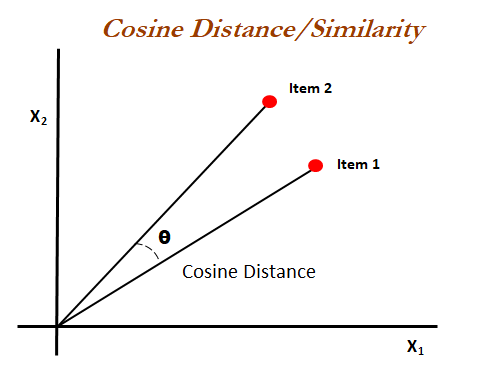

The diagram above illustrates that we measure the cosine distance between vectors by measuring the angle between them. Given this distance we know the similarity between the vectors, because:

<center>
  <code>
  similarity = 1 - distance
  </code>
</center>

The similarity between "Yale" and "Yale" reported above is 1, because there is 0 distance between the angles of those two vectors (afterall both words are represented by the same vector!) and 1 - 0 is 1. 

The similarity between "Yale" and "Harvard" reported above is ≈ 0.78 because the cosine <i>distance</i> between those two vectors is ≈ 0.21 and 1 - 0.21 ≈ 0.78!

In [ ]:
from scipy.spatial import distance

# measure the cosine distance between two word vectors
distance.cosine(model['Yale'], model['Harvard'])

0.21823042631149292

Given that cosine _distance_, we can identify the cosine _similarity_ as 1 - that distance:

In [ ]:
# define the cosine similarity between two word vectors as 1 minus their distance
cosine_similarity = 1 - distance.cosine(model['Yale'], model['Harvard'])

cosine_similarity

0.7817695736885071

That cosine similarity is the similarity score reported for the word pair "Yale" and "Harvard" above. This cosine similarity gives us a measure of just how similar these two words are (where words that appear in similar contexts have high similarity).

<details>
  <summary>A note on the equation behind cosine similarity</summary>

  In case you're interested in diving deeper into similarity measures, the cosine similarity between two vectors `a` and `b` is the dot product of those vectors divided by the product of their magnitudes. We can compute this similarity as follows using numpy:

  ```
  import numpy as np

  a = model['Yale']
  b = model['Harvard']

  np.dot(a, b) / (np.linalg.norm(a) * np.linalg.norm(b))
  ```
</details>

# Reviewing associated words

Using the techniques we have just covered, see if you can fetch the 10 words most similar to the word "bank" in the model:

In [ ]:
# type your code here
model.similar_by_vector(model['bank'], topn=10)

[('bank', 1.0),
 ('banks', 0.7440759539604187),
 ('banking', 0.690161406993866),
 ('Bank', 0.6698698401451111),
 ('lender', 0.6342284679412842),
 ('banker', 0.6092953085899353),
 ('depositors', 0.6031531691551208),
 ('mortgage_lender', 0.5797975659370422),
 ('depositor', 0.5716427564620972),
 ('BofA', 0.5714625120162964)]

Now let's see if you can answer a harder question: Is the word "bank" more similar to the word "money" or the word "river" in this model?

In [ ]:
# type your code here
sim_river = 1 - distance.cosine(model['bank'], model['river'])
sim_money = 1 - distance.cosine(model['bank'], model['money'])

print(sim_river, sim_money)

0.21523123979568481 0.2613206207752228


<details>
  <summary>Solutions</summary>

  We can fetch the 10 words that are most similar to "bank" with the following approach:

  ```python
  model.similar_by_vector(model['bank'], topn=10)
  ```

  Then, to measure the similarity between our query word bank and our two terms "money" and "river", we can use the following approach:

  ```python
  sim_river = 1 - distance.cosine(model['bank'], model['river'])
  sim_money = 1 - distance.cosine(model['bank'], model['money'])

  print(sim_river, sim_money)
  ```

  Those similarity measures show us that the word "bank" is more similar to the term "money".
</details>

# Visualizing word fields



In the code above, we examined the simialarity between two word vectors. In what follows, we'll visualize the similarity between hundreds of words at once. To do so, we'll reduce the vector representation of each word to just two dimensions, then we'll create a visualization that renders each word at its two-dimensional position. To understand how this works, let's talk a little about dimensionality reduction.

### Dimensionality reduction

As we noted above, each of the word vectors in our model is a list of 300 values (that is to say, each is a 300-dimensional vector). These "high-dimensional" datasets can be quite hard to work with and reason about. High dimensional datasets also pose specific challenges to many machine learning models (see **[The Curse of Dimensionality](https://en.wikipedia.org/wiki/Curse_of_dimensionality)**). To work around these challenges and to let us visualize some of our data so as to make it more intuitive, it's often helpful to reduce the number of dimensions required to express a given dataset.

One popular way to reduce the dimensionality of a dataset is to use a technique called [**Principal Component Analysis**](https://en.wikipedia.org/wiki/Principal_component_analysis). PCA tries to find a lower dimensional representation of a dataset by projecting that dataset down into a smaller dimensional space in a way that minimizes loss of information.

To understand PCA at an intuitive level, suppose you have points in two dimensions, and you wish to reduce the dimensionality of your dataset to a single dimension. To do so, you could find the center of the points then create a line $L$ with a random orientation that passes through that center. One can then project each point onto $L$ such that an imaginary line between the point and $L$ form a right angle. Within this "projection", each 2D point can be represented with just its position along the 1D $L$, effectively giving us a 1D representation of the point's position in its original space. Furthermore, we can use the difference between the largest and smallest values of points projected onto $L$ as a measure of the amount of "variance" or "spread" within the data captured in $L$&mdash;the greater this spread, the greater the amount of "signal" from the original dataset is represented in the projection.

If one were to slowly rotate $L$ and continue measuring the delta between the greatest and smallest values on $L$ at each orientation, one could find the orientation of the projection line that minimizes information loss. (This line of minimal information loss is shown in pink below.) Once that line is discovered, we can actually project all of our points onto that lower-dimensional embedding (see the red points below when the black line is colinear with the pink line):

<img src='https://github.com/YaleDHLab/lab-workshops/raw/master/machine-learning/images/pca.gif'>

<center><small>For a beginner-friendly deep dive into the mechanics behind this form of dimension reduction, check out Josh Starmer's <a href='https://www.youtube.com/watch?v=FgakZw6K1QQ'>step-by-step guide to PCA</a>.</small></center>

To get a better sense of how dimensionality reduction transforms vectors in more than two dimensions, we can look at the way the UMAP dimension reduction algorithm reduces the dimensionality of several 3D models of animals to 2D:

In [ ]:
from IPython.display import IFrame
IFrame('https://duhaime.s3.amazonaws.com/apps/umap-zoo/index.html', width=1100, height=560)

Let's use the UMAP dimension reduction algorithm to project our word vectors down to 2D, which will allow us to explore the data more freely! There are a few steps involved in our dimension reduction. First we need to create the list of words we want to project to 2D. Our model contains many words, and projecting them all will take some time, so let's just pull out a subset of our words.

In [ ]:
# identify all of the words present in the model
# all_words = list(model.vocab.keys())
all_words = list(model.index_to_key)

# identify the list of words we will project into 2D (these could be manually typed if you prefer)
# NB: to keep our processing fast we'll just analyze a subset of our word vectors
words = all_words[5000:5500]

`words` is now a list of strings where each string contains just a single word present in our model. If you wanted to project the vectors for a certain seleciton of words, you could define that list of words above instead.

Having selected the list of words we'll process, let's identify the 300D vector for each:

In [ ]:
# fetch the vector that corresponds to each of the words in `words`
vectors = [model[word] for word in words]

The code above uses a "list comprehension" to populate a list `vectors` that contains one 300D vector for each of our words in `words`. We could have used a traditional for loop to iterate over each item in `words` and add its vector to `vectors`, but the syntax above is a little more compact.

Having accumulated our list of vectors, let's use UMAP to project those vectors down to two dimensions:

In [ ]:
!pip install umap-learn

# import the umap-learn package
import umap

# shrink the number of units used to represent each word vector from 300 to 2
projected = umap.UMAP(n_components=2).fit_transform(vectors)

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 88.2/88.2 kB 8.5 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.1/1.1 MB 47.8 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
  Created wheel for umap-learn: filename=umap_learn-0.5.3-py3-none-any.whl size=82816 sha256=015298d89aeafbd4529532846f75b7f2e393f86069a8ff5ad3305f14f8b83b07
  Stored in directory: /root/.cache/pip/wheels/a0/e8/c6/a37ea663620bd5200ea1ba0907ab3c217042c1d035ef606acc
  Created wheel for pynndescent: filename=pynndescent-0.5.10-py3-none-any.whl size=55622 sha256=35876cbd143a2a0e20a9c0f04730bbaa2b2979ae1786059b733d97ff342f0b3b
  Stored in directory: /root/.cache/pip/wheels/4a/38/5d/f60a40a66a9512b7e5e83517ebc2d1b42d857be97d135f1096
Successfully built umap-learn pynndescent


Awesome! Now each of our words is represented by just two numbers (because UMAP projected the word vector for each to just two dimensions). Let's look at the 2D vector that corresponds to a particular word:

In [ ]:
# select the index position of a word to analyze
word_index = 17

# display the word at the target index position and the 2D vector that corresponds with that word
words[word_index], projected[word_index]

('innocent', array([0.7588829, 8.104201 ], dtype=float32))

Now that each word is represented by just two dimensions, we can visualize our data much more easily! Let's create a scatterplot of the words in `words`:

(5.4071807861328125, 10.565972328186035)

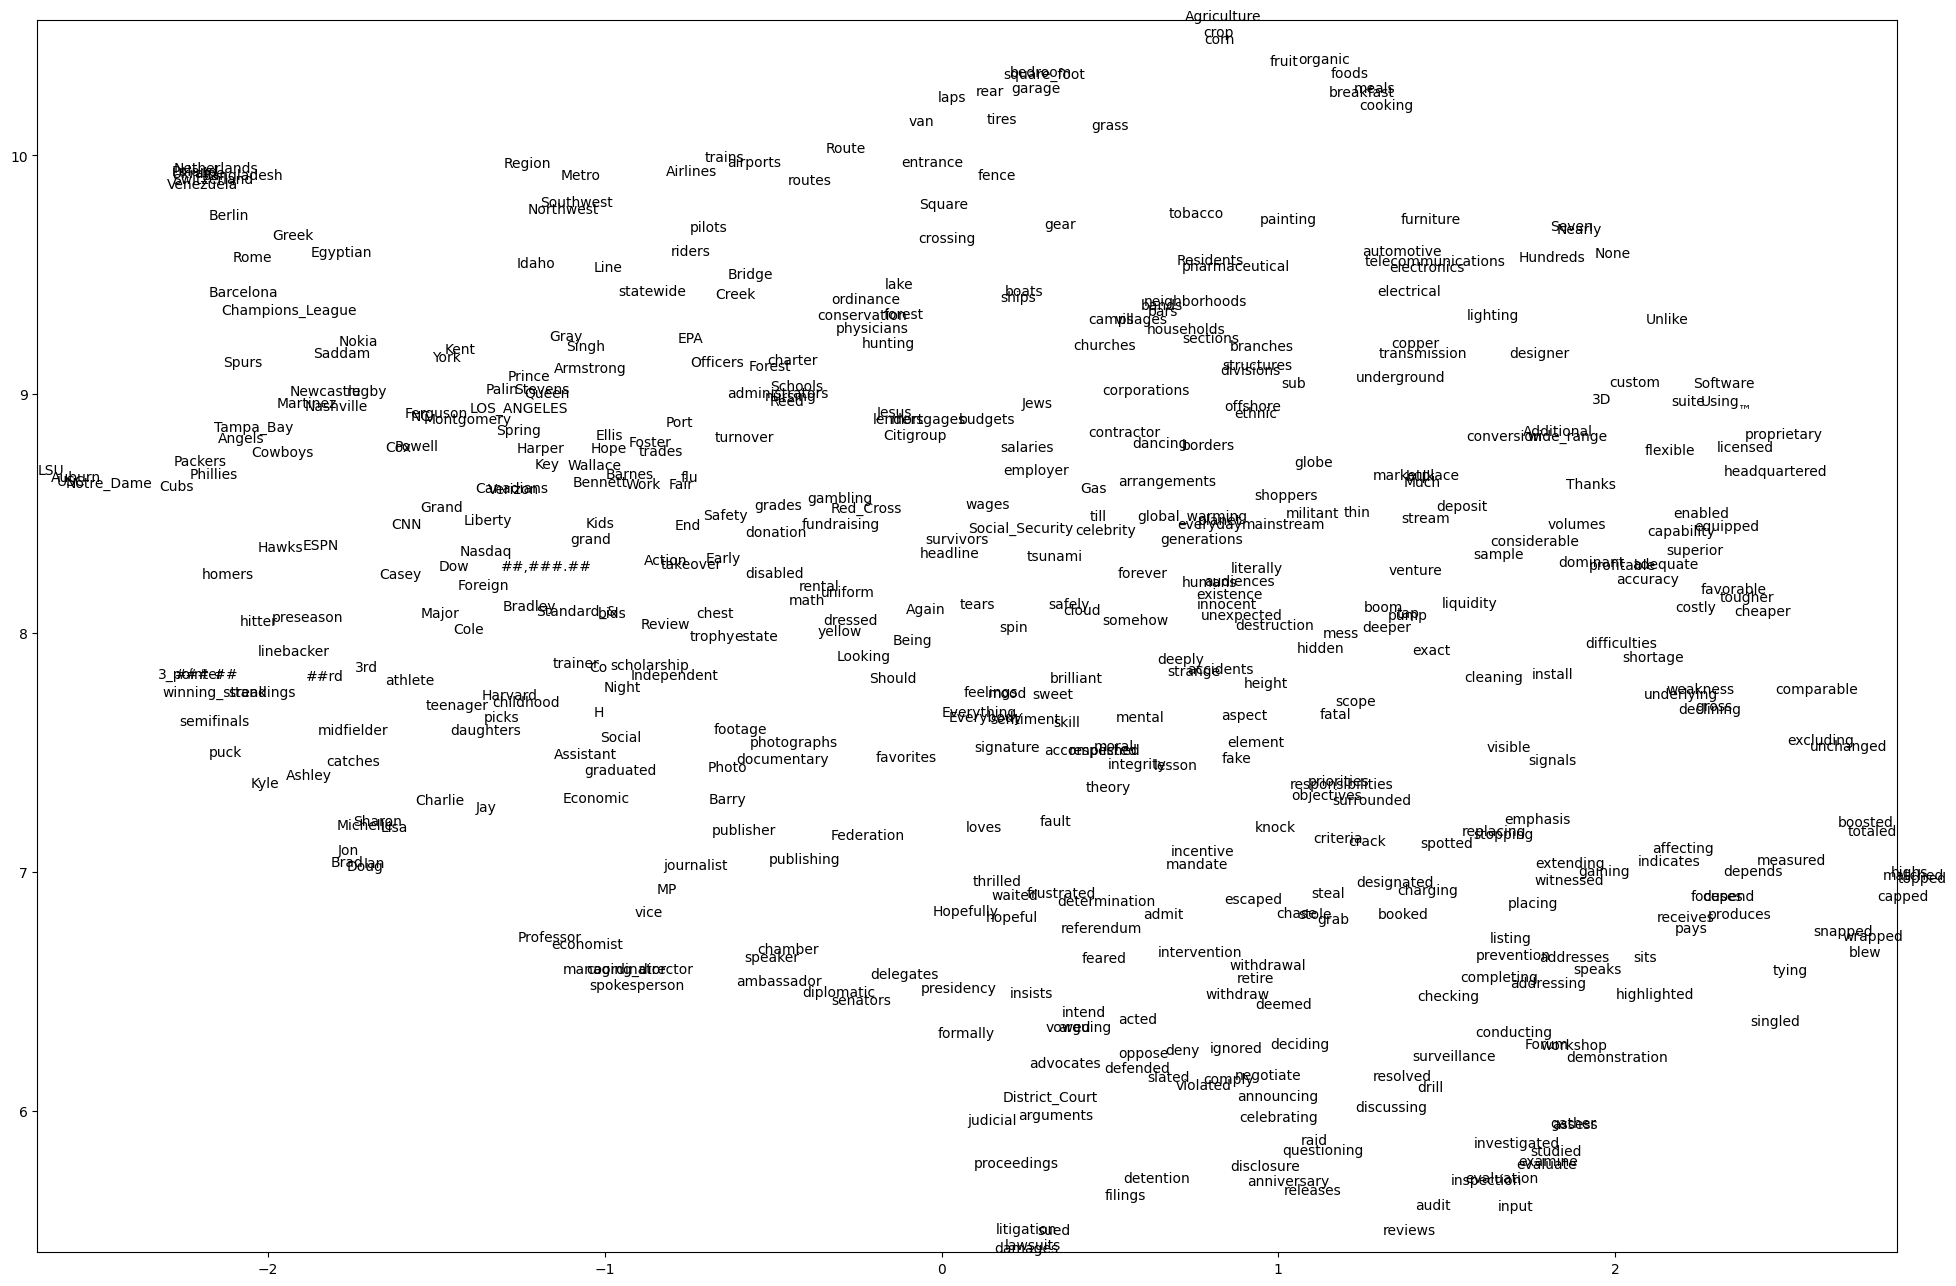

In [ ]:
%matplotlib inline 
import matplotlib.pyplot as plt

# get the list of x and y positions for our words
x, y = projected.transpose()

# initialize a plot with width 24, height 16
plt.figure(figsize=(24, 16))

# plot each word at their appropriate position
[plt.text(x[index], y[index], word) for index, word in enumerate(words)]

# set the x and y axis limits on the plot
plt.xlim(( min(x), max(x) ))
plt.ylim(( min(y), max(y) ))

There we go! Now we can start to get a sense of some of the relationships between our word vectors. For example, you might see in the plot above that there is one cluster of words associated with houses ("square_foot", "bedroom", "garage", "fence"). One of the nearby clusters contains nature words ("lake", "forest"). Between those two clusters is "grass", because homes often have grass yards and grass is present in nature!

### Reviewing dimension reduction

Take a moment to analyze one of the clusters of words that appear in the scatterplot you made above. Can you find a word that doesn't seem to belong to the cluster? Try to think through why that word or why that word might be positioned where it is...

# Hierarchical word modelling

In the cells above we examined a few different ways of analyzing the similarity between word vectors. As our last example below, we'll examine another way of analyzing similarity through "dendrograms". 

Dendrograms are tree-like structures that give a visual representation of the similarities between objects. As an example, we could take a look at the points below:

<div style='text-align: center'>
  <img src='https://raw.githubusercontent.com/YaleDHLab/lab-workshops/master/word-vectors/images/dendrogram.png'>
  <a href='https://www.displayr.com/what-is-dendrogram/'>Image by Tim Bock</a>
</div>

One can see that E and F are the closest two points in the scatterplot to the left above. E and F are therefore positioned proximate to one another in the dendrogram above to the right. D is the next most similar to E and F, and it is therefore the next closest link in the dendrogram as well. In general, the closer two observations are in the 2D space, the closer they are in the dendrogram space.

Let's create a list of words for which we'll create a dendrogram:

In [ ]:
# identify all of the words present in the model
all_words = list(model.index_to_key)

# identify the list of words we will project into 2D (these could be manually typed if you prefer)
# NB: to keep our processing fast we'll just analyze a subset of our word vectors
words = all_words[5000:5500]

Next, let's fetch a vector representation of each of these words:

In [ ]:
# fetch the vector that corresponds to each of the words in `words`
vectors = [model[word] for word in words]

The code above uses a "list comprehension" to populate a list `vectors` that contains one 300D vector for each of our words in `words`. We could have used a traditional for loop to iterate over each item in `words` and add its vector to `vectors`, but the syntax above is a little more compact.

Now that we've accumulated a list of `words` and their corresponding `vectors`, let's plot the relationships between our word vectors as a dendrogram:

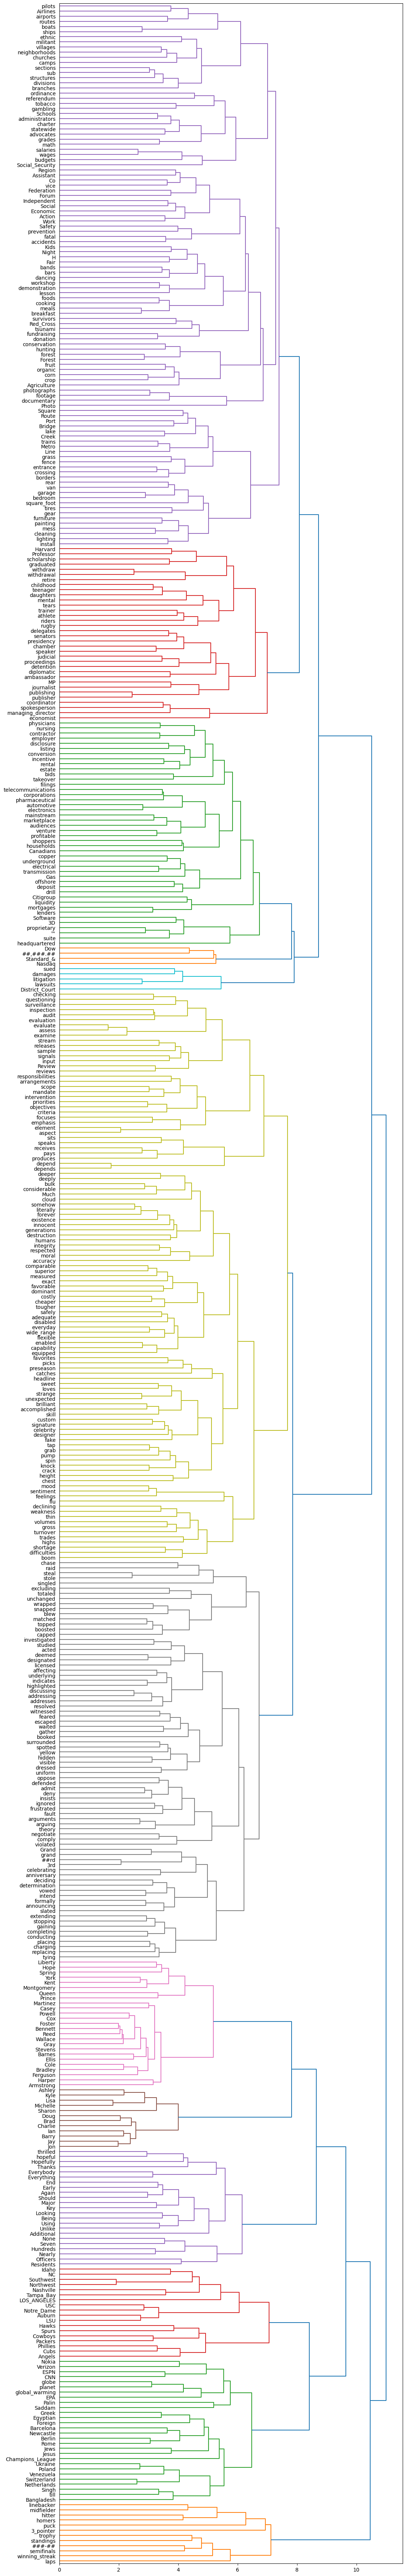

In [ ]:
from scipy.cluster.hierarchy import dendrogram, linkage
import matplotlib.pyplot as plt

# initialize a plot with a speified width, height
fig, ax = plt.subplots(figsize=(12, 90))

# create a dendrogram using `vectors` and `words` we defined above
dendrogram(linkage(vectors, 'ward'), leaf_rotation=0.0, leaf_font_size=10.0, labels=words, orientation='right')

# show the plot -- NB: you may need to double-click the plot below to see it in its entirety
plt.show()

# Reviewing dendrograms

To practice generating dendrograms, see if you can make a dendrogram plot that contains only the following list of words (NB: you may need to adjust your plot size!):

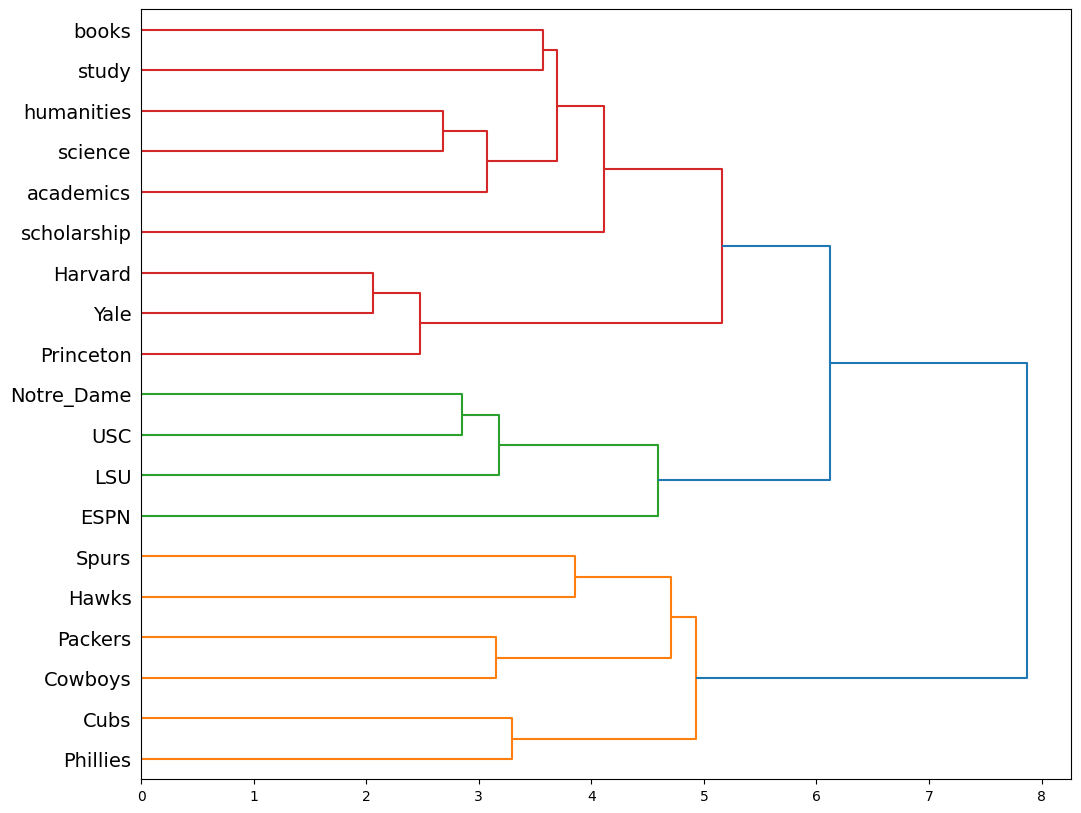

In [ ]:
# our list of words for which we'll create a dendrogram
words = ['Yale', 'Harvard', 'Princeton', 'USC', 'Notre_Dame', 'LSU', 'Hawks', 'Spurs', 'Cowboys', 'Packers', 'Phillies', 'Cubs', 'ESPN', 'academics', 'study', 'books', 'scholarship', 'science', 'humanities']

# create a dendrogram of the words above
# fetch the vector associated with each word in the list
vectors = [model[i] for i in words]

# initialize a plot with a speified width, height
fig, ax = plt.subplots(figsize=(12, 10))

# create a dendrogram using `vectors` and `words` we defined above
dendrogram(linkage(vectors, 'ward'), leaf_rotation=0.0, leaf_font_size=14.0, labels=words, orientation='right')

# show the plot
plt.show()

<details>
  <summary>Solution</summary>

  We can plot the dendrogram of these words as follows:

  ```python
  # fetch the vector associated with each word in the list
  vectors = [model[i] for i in words]

  # initialize a plot with a speified width, height
  fig, ax = plt.subplots(figsize=(12, 10))

  # create a dendrogram using `vectors` and `words` we defined above
  dendrogram(linkage(vectors, 'ward'), leaf_rotation=0.0, leaf_font_size=14.0, labels=words, orientation='right')

  # show the plot
  plt.show()
  ```


</details>

Looking at your plot, what can you say about the presence of Ivy-league collegiate sports vs non-Ivy-league collegiate sports on ESPN? 

What can you say about ESPN's relationship to collegiate and professional sports?

# Training custom models

We've done some great work using a pretrained Word2Vec model above. Now let's learn how we can train new Word2Vec models on custom datasets. 

The first step in training a custom model will be to upload your data to Colab, or download your data from some publically accessible url into Colab. Let's download some data on which to train some custom models:

In [ ]:
!wget -nc https://lab-workshops.s3-us-west-2.amazonaws.com/word-vectors/pop-lyrics.txt

--2023-05-30 00:52:17--  https://lab-workshops.s3-us-west-2.amazonaws.com/word-vectors/pop-lyrics.txt
Resolving lab-workshops.s3-us-west-2.amazonaws.com (lab-workshops.s3-us-west-2.amazonaws.com)... 52.92.229.114, 3.5.79.148, 3.5.81.129, ...
Connecting to lab-workshops.s3-us-west-2.amazonaws.com (lab-workshops.s3-us-west-2.amazonaws.com)|52.92.229.114|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 46281201 (44M) [text/plain]
Saving to: ‘pop-lyrics.txt’

pop-lyrics.txt      100%[===================>]  44.14M  22.9MB/s    in 1.9s    

2023-05-30 00:52:20 (22.9 MB/s) - ‘pop-lyrics.txt’ saved [46281201/46281201]



This data (derived from a [dataset on Kaggle.com](https://www.kaggle.com/neisse/scrapped-lyrics-from-6-genres)) contains lyrics from pop songs. Each line contains the lyrics to a different song. 

In order to train a Word2Vec model on this data, we need to feed `gensim` a list of lists where sublists contain the words from a single song/document. Let's create this list of lists now:

In [ ]:
# initialize a list in which we'll store our wordlists
word_lists = []

# read the pop-lyrics file
text = open('pop-lyrics.txt').read()

# split the file into a list of lines
lines = text.split('\n')

# for each line in the file
for line in lines:

  # split the line into a list of words
  words = line.split()

  # add the word list to our word lists
  word_lists.append(words)

`word_lists` now contains a list of words for each of our documents. Let's look at the words from our first song:

In [ ]:
print(word_lists[0])

['i', 'could', 'feel', 'at', 'the', 'time', 'there', 'was', 'no', 'way', 'of', 'knowing', 'fallen', 'leaves', 'in', 'the', 'night', 'who', 'can', 'say', 'where', "they're", 'blowing', 'as', 'free', 'as', 'the', 'wind', 'hopefully', 'learning', 'why', 'the', 'sea', 'on', 'the', 'tide', 'has', 'no', 'way', 'of', 'turning', 'more', 'than', 'this', 'you', 'know', "there's", 'nothing', 'more', 'than', 'this', 'tell', 'me', 'one', 'thing', 'more', 'than', 'this', 'you', 'know', "there's", 'nothing', 'it', 'was', 'fun', 'for', 'a', 'while', 'there', 'was', 'no', 'way', 'of', 'knowing', 'like', 'a', 'dream', 'in', 'the', 'night', 'who', 'can', 'say', 'where', "we're", 'going', 'no', 'care', 'in', 'the', 'world', 'maybe', "i'm", 'learning', 'why', 'the', 'sea', 'on', 'the', 'tide', 'has', 'no', 'way', 'of', 'turning', 'more', 'than', 'this', 'you', 'know', "there's", 'nothing', 'more', 'than', 'this', 'tell', 'me', 'one', 'thing', 'more', 'than', 'this', 'you', 'know', "there's", 'nothing', 'mo

Let's now train a model on our prepared data!

In [ ]:
%%time

import gensim

# train our custom Word2Vec model!
pop_model = gensim.models.Word2Vec(
  word_lists,     # a list of lists where sublists contain the words from a document
  # size=100,       # the number of dimensions in our output vectors
  window=5,       # the number of words per window in each document
  min_count=20)   # the minimum number of times a word must occur to be retained

CPU times: user 1min 32s, sys: 0 ns, total: 1min 32s
Wall time: 56 s


Great! We trained a custom Word2Vec model, and it only took a a minute and a half! 

Now let's use this model to review some of the techniques we've discussed above...

# Reviewing Gensim's Word2Vec

Let's start our analysis of our new Word2Vec model with the following challenge.

### Finding similar words

Populate `words` below with the twenty words most similar to the word "car" in the model. This list should only contain the words that are similar to "car", not the similarity between "car" and the given word!

In [ ]:
# add the 20 words most similar to the word "car" to the list of `words` below
# initialize the list in which we'll store our words
words = []

# get the vector that corresponds to car
vector = pop_model.wv['car']

# find the 20 words and similarities most similar to the 
result = pop_model.wv.similar_by_vector(vector, topn=20)

# loop over each item in `result`
for i in result:

  # add the word from this item to the list of words
  words.append(i[0])
  print(i)

('car', 0.9999998807907104)
('getaway', 0.666751503944397)
('cab', 0.591171383857727)
('coupe', 0.5858839750289917)
('seat', 0.5846661925315857)
('backseat', 0.5654765367507935)
('plane', 0.5523512959480286)
('cadillac', 0.5455514192581177)
('closet', 0.539655327796936)
('valet', 0.5385962128639221)
('crib', 0.5375091433525085)
('keys', 0.5369101166725159)
('lane', 0.5351236462593079)
('bus', 0.532271683216095)
('house', 0.5316372513771057)
('parked', 0.5306249260902405)
('mansion', 0.5274007320404053)
('park', 0.5268754959106445)
('headlights', 0.5251172184944153)
('ferrari', 0.5250479578971863)


<details>
  <summary>Solution</summary>
  We can fetch the 20 words closest to the word "car" as follows:

  ```python
  # initialize the list in which we'll store our words
  words = []

  # get the vector that corresponds to car
  vector = pop_model['car']

  # find the 20 words and similarities most similar to the 
  result = pop_model.similar_by_vector(vector, topn=20)

  # loop over each item in `result`
  for i in result:

    # add the word from this item to the list of words
    words.append(i[0])

  ```
</details>

### Retrieving vectors that correspond to `words`

Next let's populate `vectors` with the vector representation of each of our words in `words` (in the same order):



In [ ]:
# add the vectors that correspond to each of our words below
vectors = []
vectors = [pop_model.wv[i] for i in words]

<details>
  <summary>Solution</summary>

  We can populate our list of vectors as follows:

  ```python
  vectors = [pop_model[i] for i in words]
  ```

</details>

### Plotting a dendrogram using `words` and `vectors`

Finally, let's use `words` and `vectors` to plot a dendrogram of our identified terms!

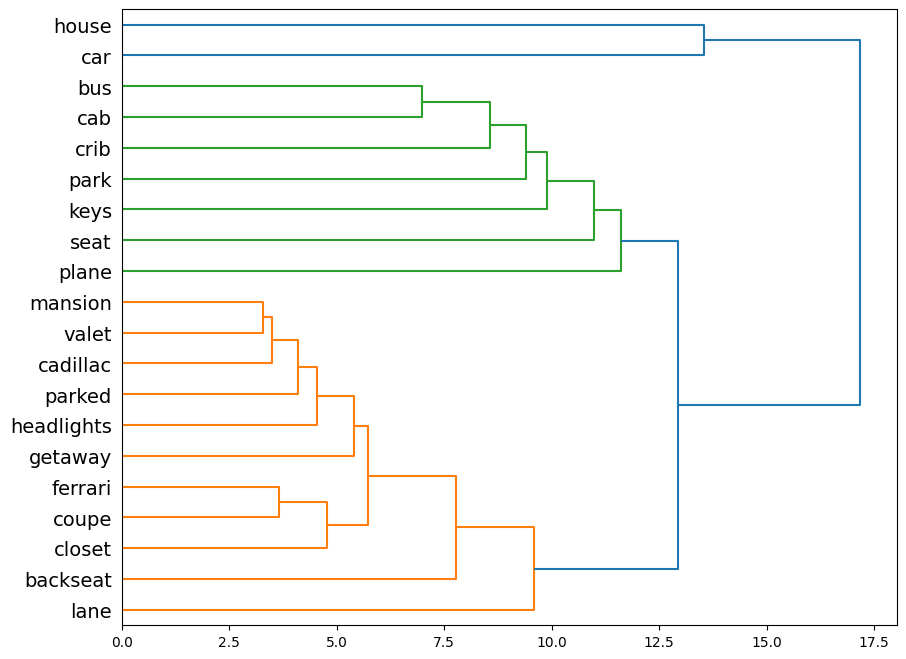

In [ ]:
# plot your dendrogram using `words` and `vectors` below
# initialize a plot with a speified width, height
fig, ax = plt.subplots(figsize=(10, 8))

# create a dendrogram using `vectors` and `words` we defined above
dendrogram(linkage(vectors, 'ward'), leaf_rotation=0.0, leaf_font_size=14.0, labels=words, orientation='right')

# show the plot
plt.show()

<details>
  <summary>Solution</summary>

  We can plot this dendrogram with the following code:

  ```python
  # initialize a plot with a speified width, height
  fig, ax = plt.subplots(figsize=(10, 8))

  # create a dendrogram using `vectors` and `words` we defined above
  dendrogram(linkage(vectors, 'ward'), leaf_rotation=0.0, leaf_font_size=14.0, labels=words, orientation='right')

  # show the plot
  plt.show()

  ```
</details>

Congratulations! You've now trained your very own word vector model and have plotted some dendrograms of words associated with a particular idea in your corpus! You're fast on your way to reproducing the results we saw in Jonathan Fitzgerald's article earlier this week!

# Going further with word vectors

If you would like to explore word vectors a little more deeply, feel free to consult any of the following resources:

* Ben Schmidt's [Vector Space Models for the Digital Humanities](http://bookworm.benschmidt.org/posts/2015-10-25-Word-Embeddings.html). Schmidt's article gives a great overview of some of the fun things one can do with word vectors.
* Ryan Heuser's [Word Vectors in the Eighteenth Century](https://ryanheuser.org/word-vectors-1/) Ryan Heuser based much of his doctoral dissertation on using word vectors to study the changes in abstract concepts over time; this series offers a concise overview of some of his findings.
* Stanford University's [GloVe: Global Vectors for Word Representation](https://nlp.stanford.edu/projects/glove/): Stanford's GloVe vectors are one of the chief competitors to the Word2Vec model we've been using above. If you are looking for pretrained word vectors that are easy to work with, the GloVe project would be a great place to start!